<a href="https://colab.research.google.com/github/SighanoCel/My-data-science-project/blob/main/banking_churn_with_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This project focuses on predicting customer churn in the banking sector using a deep learning algorithm. A TensorFlow Keras Sequential model will be developed to classify whether a customer is likely to leave the bank. Since churn datasets are often highly imbalanced—with far fewer customers churning than staying—SMOTE (Synthetic Minority Oversampling Technique) from the imblearn library will be applied to balance the target classes and improve model performance. Beyond churn prediction, the model’s probability scores (churn risk) will be binned to support a Return on Investment (ROI) analysis, allowing the bank to quantify the financial impact of retention strategies across different risk segments. This end-to-end approach combines predictive modeling with actionable business insights to guide targeted interventions and maximize profitability.

In [88]:
# importing python liabraries to clean, analyze and visualize data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [89]:
# loading the raw datset.

df= pd.read_csv('/content/drive/MyDrive/Keaggle datasets project/Classification/Customer-Churn-Records.csv')

df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


In [90]:
# dataset glossary to understand the meaning of the features.

with open('/content/drive/MyDrive/Keaggle datasets project/Classification/Bank Churn Glossary.txt','r') as f:

  print(f.read())

RowNumber—corresponds to the record (row) number and has no effect on the output.
CustomerId—contains random values and has no effect on customer leaving the bank.
Surname—the surname of a customer has no impact on their decision to leave the bank.
CreditScore—can have an effect on customer churn, since a customer with a higher credit score is less likely to leave the bank.
Geography—a customer’s location can affect their decision to leave the bank.
Gender—it’s interesting to explore whether gender plays a role in a customer leaving the bank.
Age—this is certainly relevant, since older customers are less likely to leave their bank than younger ones.
Tenure—refers to the number of years that the customer has been a client of the bank. Normally, older clients are more loyal and less likely to leave a bank.
Balance—also a very good indicator of customer churn, as people with a higher balance in their accounts are less likely to leave the bank compared to those with lower balances.
NumOfPr

In [91]:
# dropping the irrelevant dataset for our analysis and modeling

df= df.drop(['RowNumber','CustomerId','Surname'],axis=1)

In [92]:
# renaming the target variable. from exited to churn just for simplicity

df= df.rename(columns={'Exited':'churn'})
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,churn,Complain,Satisfaction Score,Card Type,Point Earned
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


In [93]:
# let's check if there are missing and/or duplicated values within the dataset.
# we notice that the dataset is complete. may be it has been cleaned before.

print(df[df.isnull()].sum())

print(df[df.duplicated()].sum())

CreditScore           0.0
Geography               0
Gender                  0
Age                   0.0
Tenure                0.0
Balance               0.0
NumOfProducts         0.0
HasCrCard             0.0
IsActiveMember        0.0
EstimatedSalary       0.0
churn                 0.0
Complain              0.0
Satisfaction Score    0.0
Card Type               0
Point Earned          0.0
dtype: object
CreditScore             0
Geography               0
Gender                  0
Age                     0
Tenure                  0
Balance               0.0
NumOfProducts           0
HasCrCard               0
IsActiveMember          0
EstimatedSalary       0.0
churn                   0
Complain                0
Satisfaction Score      0
Card Type               0
Point Earned            0
dtype: object


In [94]:
# checking the pearson correlation between the target variable and the other features, we notice that
# the feature "Complain" is linearly correlated to the "churn" at almost a 100%.
# we decide to remove as it's a strong indicator of a potential data leakage and could definitely lead to overfitting.
# If this feature is used in training, the model might simply learn to predict churn
# whenever a customer has a complaint, without truly learning the underlying patterns that lead to churn for customers who don't complain.

print(df.corr(method='pearson',numeric_only=True)['churn'].sort_values(ascending=False))

df=df.drop('Complain',axis=1)

churn                 1.000000
Complain              0.995693
Age                   0.285296
Balance               0.118577
EstimatedSalary       0.012490
Point Earned         -0.004628
Satisfaction Score   -0.005849
HasCrCard            -0.006976
Tenure               -0.013656
CreditScore          -0.026771
NumOfProducts        -0.047611
IsActiveMember       -0.156356
Name: churn, dtype: float64


This algorithm in the next cell helps to identify which features have different average values for customers who churn compared to those who don't, providing insights into potential drivers of churn.
For example Churned customers, on average, are older (44.8 years) than non-churned customers (37.4 years). This suggests that older customers might be more likely to churn.
 In addition, Churned customers have a slightly higher average balance (91109.48) compared to non-churned customers (72742.75). This is interesting, as one might expect customers with higher balances to be less likely to churn.


In [95]:
# let's group data where each row represents a churn group (0 or 1),
# and the columns show the average value of each numeric feature for that group.


df.groupby('churn').mean(numeric_only=True)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Satisfaction Score,Point Earned
churn,,,,,,,,,,
0,651.837855,37.408063,5.032781,72742.750663,1.544210,0.707109,0.554635,99726.853141,3.017960,607.044084
1,645.414622,44.835623,4.934740,91109.476006,1.475466,0.699215,0.360648,101509.908783,2.997547,604.448479


## Categorical features encoding

This section focuses on converting categorical features (like Geography, Gender, and Card Type) into a numerical format that can be used by the deep learning model. One-hot encoding is applied to create binary columns for each category, which helps the model interpret these non-numerical features effectively. The "drop_first =True" option is used to mitigate multicollinearity. Afterwards, these one-hot encoded features will be concatenated with the numerical features to create the final dataset for modeling.



In [96]:
features_object= df.select_dtypes(include='object')
features_digit = df.select_dtypes(exclude='object')

object_enconded= pd.get_dummies(features_object,drop_first=True, dtype=int)

data = pd.concat([object_enconded, features_digit],axis=1)

In [97]:
data

,Geography_Germany,Geography_Spain,Gender_Male,Card Type_GOLD,Card Type_PLATINUM,Card Type_SILVER,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,churn,Satisfaction Score,Point Earned
0,0,0,0,0,0,0,619,42,2,0.00,1,1,1,101348.88,1,2,464
1,0,1,0,0,0,0,608,41,1,83807.86,1,0,1,112542.58,0,3,456
2,0,0,0,0,0,0,502,42,8,159660.80,3,1,0,113931.57,1,3,377
3,0,0,0,1,0,0,699,39,1,0.00,2,0,0,93826.63,0,5,350
4,0,1,0,1,0,0,850,43,2,125510.82,1,1,1,79084.10,0,5,425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,1,0,0,0,771,39,5,0.00,2,1,0,96270.64,0,1,300
9996,0,0,1,0,1,0,516,35,10,57369.61,1,1,1,101699.77,0,5,771
9997,0,0,0,0,0,1,709,36,7,0.00,1,0,1,42085.58,1,3,564
9998,1,0,1,1,0,0,772,42,3,75075.31,2,1,0,92888.52,1,2,339


In [98]:
# By printing the info for the initial Dataframe and the final dataset for modeling,
# We can compare their structure, data types, and see the effect
# of the one-hot encoding on the columns and memory usage.

print(data.info())
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Geography_Germany   10000 non-null  int64  
 1   Geography_Spain     10000 non-null  int64  
 2   Gender_Male         10000 non-null  int64  
 3   Card Type_GOLD      10000 non-null  int64  
 4   Card Type_PLATINUM  10000 non-null  int64  
 5   Card Type_SILVER    10000 non-null  int64  
 6   CreditScore         10000 non-null  int64  
 7   Age                 10000 non-null  int64  
 8   Tenure              10000 non-null  int64  
 9   Balance             10000 non-null  float64
 10  NumOfProducts       10000 non-null  int64  
 11  HasCrCard           10000 non-null  int64  
 12  IsActiveMember      10000 non-null  int64  
 13  EstimatedSalary     10000 non-null  float64
 14  churn               10000 non-null  int64  
 15  Satisfaction Score  10000 non-null  int64  
 16  Point

# Modeling

In [99]:
# let's import the varoìious sklearn libraries helpful to prepare the data and perform
# deep leaning task (split data, training the model, predicting and evaluating)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay



In [100]:
# here we prepare our dataset for modeling by separating
# the features (independent variables) from the target variable (dependent variable).

X= data.drop('churn',axis=1)

y= df['churn'].values

In [101]:
# let's splits our dataset into training and testing sets.
# This is a crucial step in deep learning to evaluate how well our model generalizes to unseen data.

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=1,test_size=0.3, stratify=y)

### Why Standard Scaling for Deep Neural Networks?

Standard scaling is particularly helpful for deep sequential neural networks because:

- first of all for Faster Convergence. Neural networks often use gradient descent-based optimization algorithms. Scaling features to have zero mean and unit variance can speed up the convergence of these algorithms.
- to improve performance. Features on different scales can lead to some features dominating others during training. Scaling ensures that all features contribute more equally to the model's learning process, potentially leading to better performance.
- for Activation Functions. Many activation functions used in neural networks (like sigmoid and tanh) are sensitive to the range of input values. Scaling can help prevent issues where inputs are in the saturated regions of these functions, where gradients are very small, slowing down learning.

In [102]:
# Here we create an instance of a standerscaler and fit it on the
# independent variable train and test set.

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.fit_transform(X_test)

#### Handling Imbalanced Data with SMOTE

Churn datasets often have a significant imbalance between the number of customers who churn (minority class) and those who don't (majority class). This imbalance can lead to models that are biased towards the majority class and perform poorly in identifying the minority class (churned customers), which is usually the class of most interest.

To address this, the Synthetic Minority Oversampling Technique (SMOTE) from the "imblearn" library is used. SMOTE works by creating synthetic examples of the minority class based on existing minority class samples. This helps to balance the class distribution in the training data, allowing the model to learn the patterns of the minority class more effectively and potentially improve its performance in predicting churn.

In [103]:
# Here we import the necessary library to manage the target imbalance.
# adding also a collection library to use the counter on the target value
# to check the effectiveness of the SMOTE oversampling.

from imblearn.over_sampling import SMOTE,ADASYN
from collections import Counter

In [104]:
# Let's create an instance of a SMOTE oversampling to fit it on the train set
# with the minority class setted at the 60% of the majority class as the sampling strategy
# and 2 nearest neighbours cluster along which it creates the new synthetic values
over_smote= SMOTE(sampling_strategy=0.4,random_state=1,k_neighbors=2)
X_train_smote, y_train_smote= over_smote.fit_resample(X_train_scaled,y_train)

# The counter here show the differences between the previous  label train set
# and the oversampled one.
print(Counter(y_train))
print(Counter(y_train_smote))

Counter({np.int64(0): 5573, np.int64(1): 1427})
Counter({np.int64(0): 5573, np.int64(1): 2229})


In this subpart, a sequential deep learning model is built using TensorFlow Keras, with dense layers and dropout for regularization. The model is compiled with the 'adam' optimizer and 'binary_crossentropy' loss function, and 'recall' is used as a metric to evaluate the model's performance in identifying churned customers.

Finally, the trained model is used to make predictions on the scaled test set, and the results are evaluated using a confusion matrix and classification report to assess the model's accuracy, precision, recall, and F1-score.

In [105]:
# Let us import the necessary libraries to built a sequential
# neural network model with the appropriate layers for a deep patterns learning

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers

In [106]:
# create an instance of the Sequential deep learning model

model = Sequential()

In [107]:

# add the input and first hidden layers
# The first algorithm adds a dense layer with 64 neurons (units=64). It uses the ReLU (Rectified Linear Unit) activation function,
# which rectify the linearity of the dense layer. "input_dim=X_train_smote.shape[1]" specifies that the input layer has 16 features, the number of columns in our X_train_smote
# data after one-hot encoding and smote oversampling technique.
# model.add(Dropout(0.2)): This adds a dropout layer with a dropout rate of 0.2.
#This means that during training, 20% of the neurons in the previous layer (the dense layer with 64 units)
# will be randomly turned off. This helps to prevent the model from overfitting to the training data.

model.add(Dense(units=64,activation='relu',input_dim=X_train_smote.shape[1],kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.2))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [108]:

# add the hidden layers

# Here we continue building and then compiles the sequential deep learning model:
# We add another dense hidden layer with 32 neurons and uses the ReLU activation function.
# we add another dropout layer with a dropout rate of 0.2 to further prevent overfitting.

model.add(Dense(units=32, activation='relu',kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.2))


# add the output layers
# we add the output layer with 1 neuron since this is a binary classification
# and we use the sigmoid activation function which outputs a value between 0 and 1
# interpreted as the probability of the customer churning.

model.add(Dense(units=1, activation='sigmoid',kernel_initializer='glorot_uniform'))

# Then we compile the model with an Adam optimizer, an algorithm
# suitable for training neural networks, a binary_crossentropy loss function which measures how well
# the model's predicted propabilities match the actual label.As metric we use the recall, which
# asses how well the model can identify the positive instance (churn customers)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['recall'])

In [109]:
model.fit(X_train_smote,y_train_smote,epochs=60,verbose=False)

In [110]:
# this code helps to predicted churn probabilities for each customer in the test set
# the output here are the probabilities of positive churn (class 1) for each customer, because we
# choosed the sigmoid activation in the output dense layer of the model.
# A score closer to 1 indicates a higher likelihood of the customer churning,
# while a score closer to 0 indicates a lower likelihood.

prediction = model.predict(X_test_scaled)

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


### Adjusting Classification Threshold and Evaluating Performance

To prioritize identifying churned customers (high recall) even at the cost of some precision, we can lower the classification threshold used to convert the model's predicted probabilities into binary class labels.

After adjusting the threshold, we will re-evaluate the model's performance using a classification report, paying close attention to the recall score for the churn class (class 1).

In [111]:
# Let's try a lower threshold, for example, 0.4
threshold = 0.4

# Convert prediction probabilities to binary labels using the threshold
prediction_binary = (prediction > threshold)

# Print the classification report
print(f"Classification Report with Threshold = {threshold}")
print(classification_report(y_test, prediction_binary))

# Calculate the confusion matrix
confusion_matrix(y_test, prediction_binary)

Classification Report with Threshold = 0.4
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      2389
           1       0.57      0.63      0.60       611

    accuracy                           0.83      3000
   macro avg       0.74      0.75      0.75      3000
weighted avg       0.84      0.83      0.83      3000



array([[2101,  288],
       [ 226,  385]])

In [112]:
# Here we show futher metrics to check the model performance in idntifying churn customers

loss,accuracy= model.evaluate(X_test_scaled,y_test)

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3986 - recall: 0.5787


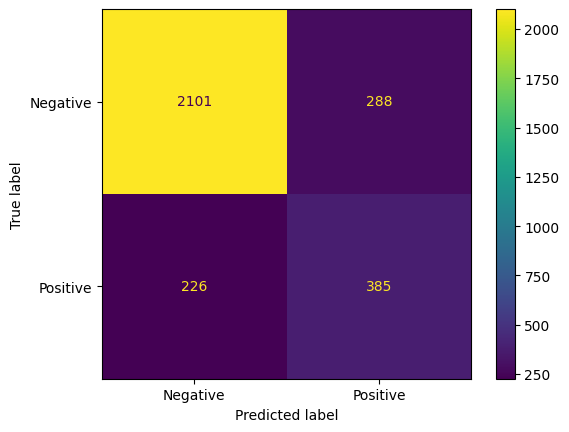

In [113]:
# Here we compute the confusion matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay(confusion_matrix(y_test,prediction_binary),display_labels=['Negative','Positive']).plot()
plt.show()

In [114]:
#This confusion matrix shows how well the model performed on the data it was trained on,
# providing insights into whether the model is overfitting or underfitting the training data.
#Comparing this to the test set confusion matrix (calculated in the previous cell) helps assess the model's generalization ability.


train_prediction = model.predict(X_train_smote)

train_prediction_binary= (train_prediction>threshold)

print(confusion_matrix (y_train_smote,train_prediction_binary))

print(classification_report(y_train_smote,train_prediction_binary))

244/244 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
[[4974  599]
 [ 526 1703]]
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      5573
           1       0.74      0.76      0.75      2229

    accuracy                           0.86      7802
   macro avg       0.82      0.83      0.83      7802
weighted avg       0.86      0.86      0.86      7802



In [115]:
# here we import the mljar-scikit-plot
# library, which is used for creating various plots to evaluate machine learning models.

! pip install mljar-scikit-plot

import scikitplot as skplt

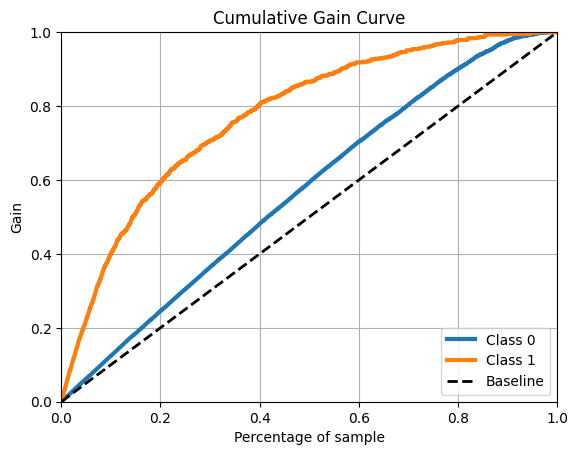

In [116]:
# The plot_cumulative_gain function requires the probabilities for each class.
# Since this is a binary classification model with a sigmoid output,
# the 'prediction' variable contains the probabilities for the positive class (churn).
# We need to format this as a 2D array where the second column is the probability of the positive class.
# The first column will be the probability of the negative class (1 - probability of positive class).

predicted_probas = np.c_[1-prediction,prediction]

# Plot the cumulative gain curve
skplt.metrics.plot_cumulative_gain(y_test, predicted_probas)
plt.title('Cumulative Gain Curve')
plt.show()

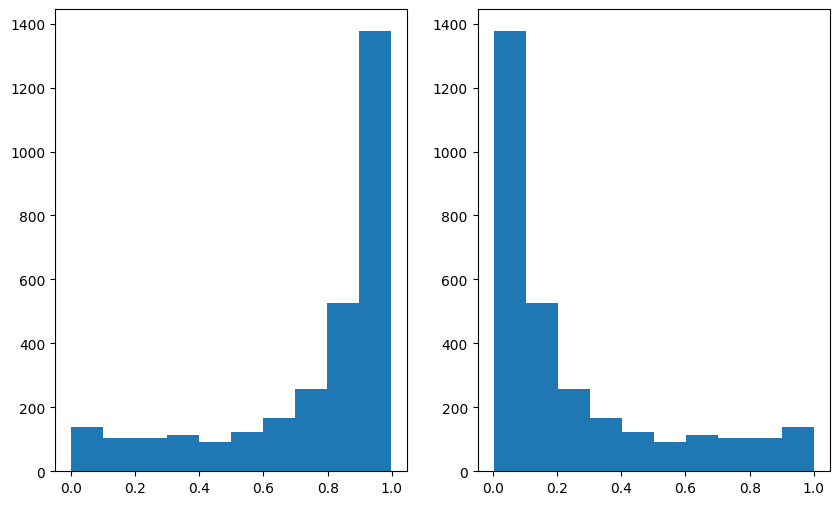

In [117]:
# in this cell we generate two histograms to visualize the distribution of the predicted probabilities for each class

fig,ax = plt.subplots(1,2, figsize=(10,6))

ax[0].hist(predicted_probas[:,0])
ax[1].hist(predicted_probas[:,1]);

##Presenting ROI to Business Users

In this part we will try to analyze the return on investment in order to evaluate the financial benefit of using a churn prediction model to retain customers.

In [118]:
# let's hypotize the Costs and the Benefits
# the contact_cost is the amount of money we spend
# every time we call a custumer that is predicted to churn
# and the revenue_profit is the estimated benefit we can have by retaining
# a potential churner.

contact_cost = 3
revenue_profit = 40


class_score= np.arange(0.0,1.01,0.01)

In [119]:
# let's build a dataset, with 2 columns, the first being the target test set
# from our original dataset, and the secong column, the predicted probabilities
# of the positive churn class from our sequential neural network model.

roi_analysis = pd.DataFrame(columns=['target','score'])

roi_analysis['target'] = y_test

roi_analysis['score'] = prediction

roi_analysis.sort_values('score',ascending=False)

,target,score
1901,1,0.999988
1211,1,0.999971
505,1,0.999964
2997,1,0.999963
2882,1,0.999954
...,...,...
2208,0,0.003409
354,0,0.003015
2454,0,0.002963
2184,0,0.002714


In [120]:

# In the same dataset we create another column derivated
# from the binning of the positive probalities of churn risk
# based on the range we built with numpy.
# the aim is to group customers into different churn risk categories
# and then counts how many customers fall into each bin.

roi_analysis['score_bin'] = pd.cut(roi_analysis['score'],bins= class_score,include_lowest=True,labels=False)

#roi_analysis['score_bin']= pd.cut(roi_analysis['score'], bins=class_score,include_lowest=True)
# we execute the previews line of code if we want to visualize the score bin original labels

roi_analysis


,target,score,score_bin
0,0,0.046113,4
1,1,0.214041,21
2,0,0.023814,2
3,0,0.079661,7
4,0,0.756703,75
...,...,...,...
2995,0,0.213759,21
2996,0,0.004636,0
2997,1,0.999963,99
2998,0,0.383292,38


In [121]:


roi_analysis['score_bin'].value_counts().sort_index()


,count
score_bin,
0,106
1,215
2,199
3,147
4,146
...,...
95,16
96,15
97,6


In [122]:
# Calculating the total number of churned customers in our test set (y_test)
# which will be divided by the cumulative sum of the target for each score_bin

tot_churn_test = np.sum(y_test==1)

# Here we group the database by the score_bin column created and apply aggregation functions
# to the data that will count (reported) and sum(hit) the total customer in each score_bin
# Since 'target' contains 0 and 1 (where 1 means churn),
# the sum represents the number of actual churned customers within that bin.

roi_analysis_agg = roi_analysis.groupby('score_bin').agg(reported=('target','count'), hit= ('target','sum'))

roi_analysis_agg

,reported,hit
score_bin,,
0,106,0
1,215,4
2,199,6
3,147,8
4,146,8
...,...,...
95,16,14
96,15,14
97,6,5


In [123]:

# we compute some cumulative sum

roi_analysis_agg['reported_cum']= roi_analysis_agg['reported'].cumsum()

roi_analysis_agg['hit_cum']= roi_analysis_agg['hit'].cumsum()

roi_analysis_agg

,reported,hit,reported_cum,hit_cum
score_bin,,,,
0,106,0,106,0
1,215,4,321,4
2,199,6,520,10
3,147,8,667,18
4,146,8,813,26
...,...,...,...,...
95,16,14,2932,545
96,15,14,2947,559
97,6,5,2953,564


In [124]:
# here we compute some metrics from the cumulative aggregation of the target()
# for example to compute the precision, we have to calculate the ratio between the actual positive
# churn and the total number of customer for each_bin.

roi_analysis_agg['precision']= roi_analysis_agg['hit_cum']/roi_analysis_agg['reported_cum']

# as we said above to compute the recall we calculated
# the total of the customers who churned from the original test set.
# and we divide this last by the cumulated sum of actual positive churn for each score_bin

roi_analysis_agg['recall']= roi_analysis_agg['hit_cum']/tot_churn_test

# the first calculation purpose is to represent the total cost incurred if you were to contact
# all customers with a predicted churn probability at or above the threshold corresponding to that bin.
# and the second represents the total potential revenue you could gain if you successfully retained
# all the actual churners within the targeted group (customers with a predicted churn probability
# at or above the threshold corresponding to that bin).

roi_analysis_agg['tot_contact_cost']= roi_analysis_agg['reported_cum']*contact_cost

roi_analysis_agg['tot_revenue_profit']= roi_analysis_agg['hit_cum']*revenue_profit

In [125]:
# we compute the final ROI

# what do we see? Which is the optimal threshold?
# what can we say to Marketing Boss?

roi_analysis_agg['return_on_investment'] = roi_analysis_agg['tot_revenue_profit'] - roi_analysis_agg['tot_contact_cost']

roi_analysis_agg

,reported,hit,reported_cum,hit_cum,precision,recall,tot_contact_cost,tot_revenue_profit,return_on_investment
score_bin,,,,,,,,,
0,106,0,106,0,0.000000,0.000000,318,0,-318
1,215,4,321,4,0.012461,0.006547,963,160,-803
2,199,6,520,10,0.019231,0.016367,1560,400,-1160
3,147,8,667,18,0.026987,0.029460,2001,720,-1281
4,146,8,813,26,0.031980,0.042553,2439,1040,-1399
...,...,...,...,...,...,...,...,...,...
95,16,14,2932,545,0.185880,0.891980,8796,21800,13004
96,15,14,2947,559,0.189684,0.914894,8841,22360,13519
97,6,5,2953,564,0.190992,0.923077,8859,22560,13701


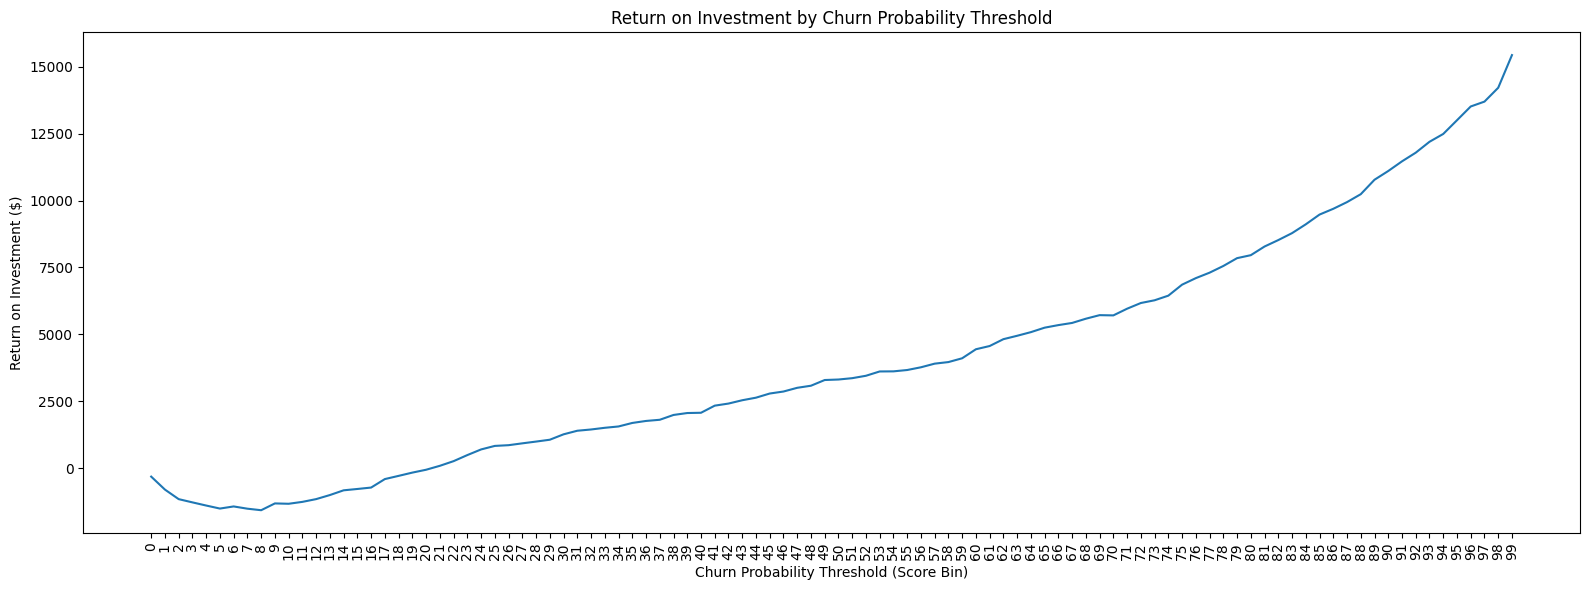

In [126]:
# The plot helps to identify the churn probability threshold (or range of thresholds)
# that yields the highest ROI, guiding decisions on which customers
# to target for retention efforts.

plt.figure(figsize=(16, 6))
plt.plot(roi_analysis_agg.index.astype(str), roi_analysis_agg['return_on_investment'])
plt.xticks(rotation=90)
plt.xlabel('Churn Probability Threshold (Score Bin)')
plt.ylabel('Return on Investment ($)')
plt.title('Return on Investment by Churn Probability Threshold')
plt.tight_layout()
plt.show()

In [127]:
# Here we calculate the score bin which can yield to the maximum return on investment

max_roi_bin = roi_analysis_agg['return_on_investment'].idxmax()
max_roi_value = roi_analysis_agg['return_on_investment'].max()

print("The peak ROI is at score bin:",max_roi_bin)
print("The maximum ROI value is: $",max_roi_value)

The peak ROI is at score bin: 99
The maximum ROI value is: $ 15440


## Report of our Return on Investment Analysis

The Return on Investment (ROI) analysis clearly demonstrates the potential financial benefits of using the churn prediction model to target retention efforts. The plot of ROI versus churn probability threshold shows a significant increase in ROI as we consider customers with higher churn risk scores.

The analysis indicates that the maximum ROI is achieved when targeting customers with a churn probability score within the range corresponding to about the 99% score bin. This means that focusing retention strategies on the customers identified by the model as having the highest likelihood of churning is the most financially beneficial approach.

By targeting customers in this high-risk segment, the bank can maximize the return on its investment in retention programs, effectively reducing churn and increasing profitability. This analysis provides actionable insights for the marketing and customer retention teams to prioritize their efforts and resources for optimal impact.